In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'skin-cancer-malignant-vs-benign:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F174469%2F505351%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240816%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240816T152150Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D22a9f05e835fa8dec035d061ef14e46abf419ba550a0874de524a4391e3f226817c285ee7d6f15858b2f64ab6737dd4aa44d8ad1efa1399a7a2156c2a3081125f4f9c590117559556e9066e7914a804acfe711ddc9db17773d9eec6d56db3bffbc690c7fbaf6abc40afc9ef6d5bf68554900dfbc659e6ce69a2b6ad3717a61f447e9c3dbd29ed0347aaba929cdaa6e3b0525c14ce24854b5ddc59d58f5c2fda02f6e1b9d65fb7043e4b2e11a71875d045279b7beae0bd6a7335f9e9d0447fa3d5009a0e3179b46c515fae851426e20f4528ce4d9677df997d035aa21485be222155daa0cf9b17c2a1ed71b16a4904124e12a14be784c3fff58b3e5526810188a'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 340467838 bytes downloaded
Downloaded and uncompressed: skin-cancer-malignant-vs-benign
Data source import complete.


# **Import needed libraries**

In [ ]:
# import system libs
import os
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.applications.resnet50 import ResNet50
from keras.applications import VGG16

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# **Loading the dataset**
> Read the training dataset into the dataframe

In [ ]:
def loading_the_data(data_dir):
    # Generate data paths with labels
    filepaths = []
    labels = []

    # Get folder names
    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)

            filepaths.append(fpath)
            labels.append(fold)

    # Concatenate data paths with labels into one DataFrame
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)

    return df

In [ ]:
# loading the training data
data_dir = '/kaggle/input/skin-cancer-malignant-vs-benign/train'
train_df = loading_the_data(data_dir)

train_df

,filepaths,labels
0,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant
1,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant
2,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant
3,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant
4,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant
...,...,...
2632,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
2633,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
2634,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
2635,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign


In [ ]:
# loading the testing data
data_dir = '/kaggle/input/skin-cancer-malignant-vs-benign/test'
ts_df = loading_the_data(data_dir)

ts_df

,filepaths,labels
0,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant
1,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant
2,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant
3,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant
4,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant
...,...,...
655,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
656,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
657,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
658,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign


# **Data preprocessing**
first we will check if the training data is balanced or not

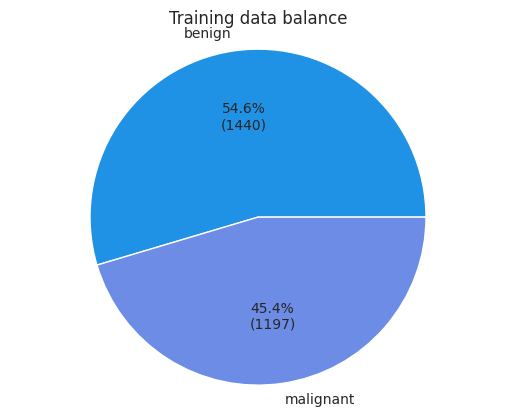

In [ ]:
data_balance = train_df.labels.value_counts()


def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)


# pie chart for data balance
plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["#2092E6","#6D8CE6"])
plt.title("Training data balance")
plt.axis("equal")
plt.show()

Data is palanced, now we will split the data

In [ ]:
# valid and test dataframe
valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

**Create image data generator**

in this step we will augment training data and converting the whoole data to numpy arrays contains the images and labels

In [ ]:
# crobed image size
batch_size = 8
img_size = (224, 224)

tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 2637 validated image filenames belonging to 2 classes.
Found 330 validated image filenames belonging to 2 classes.
Found 330 validated image filenames belonging to 2 classes.


**Display sample from train data**

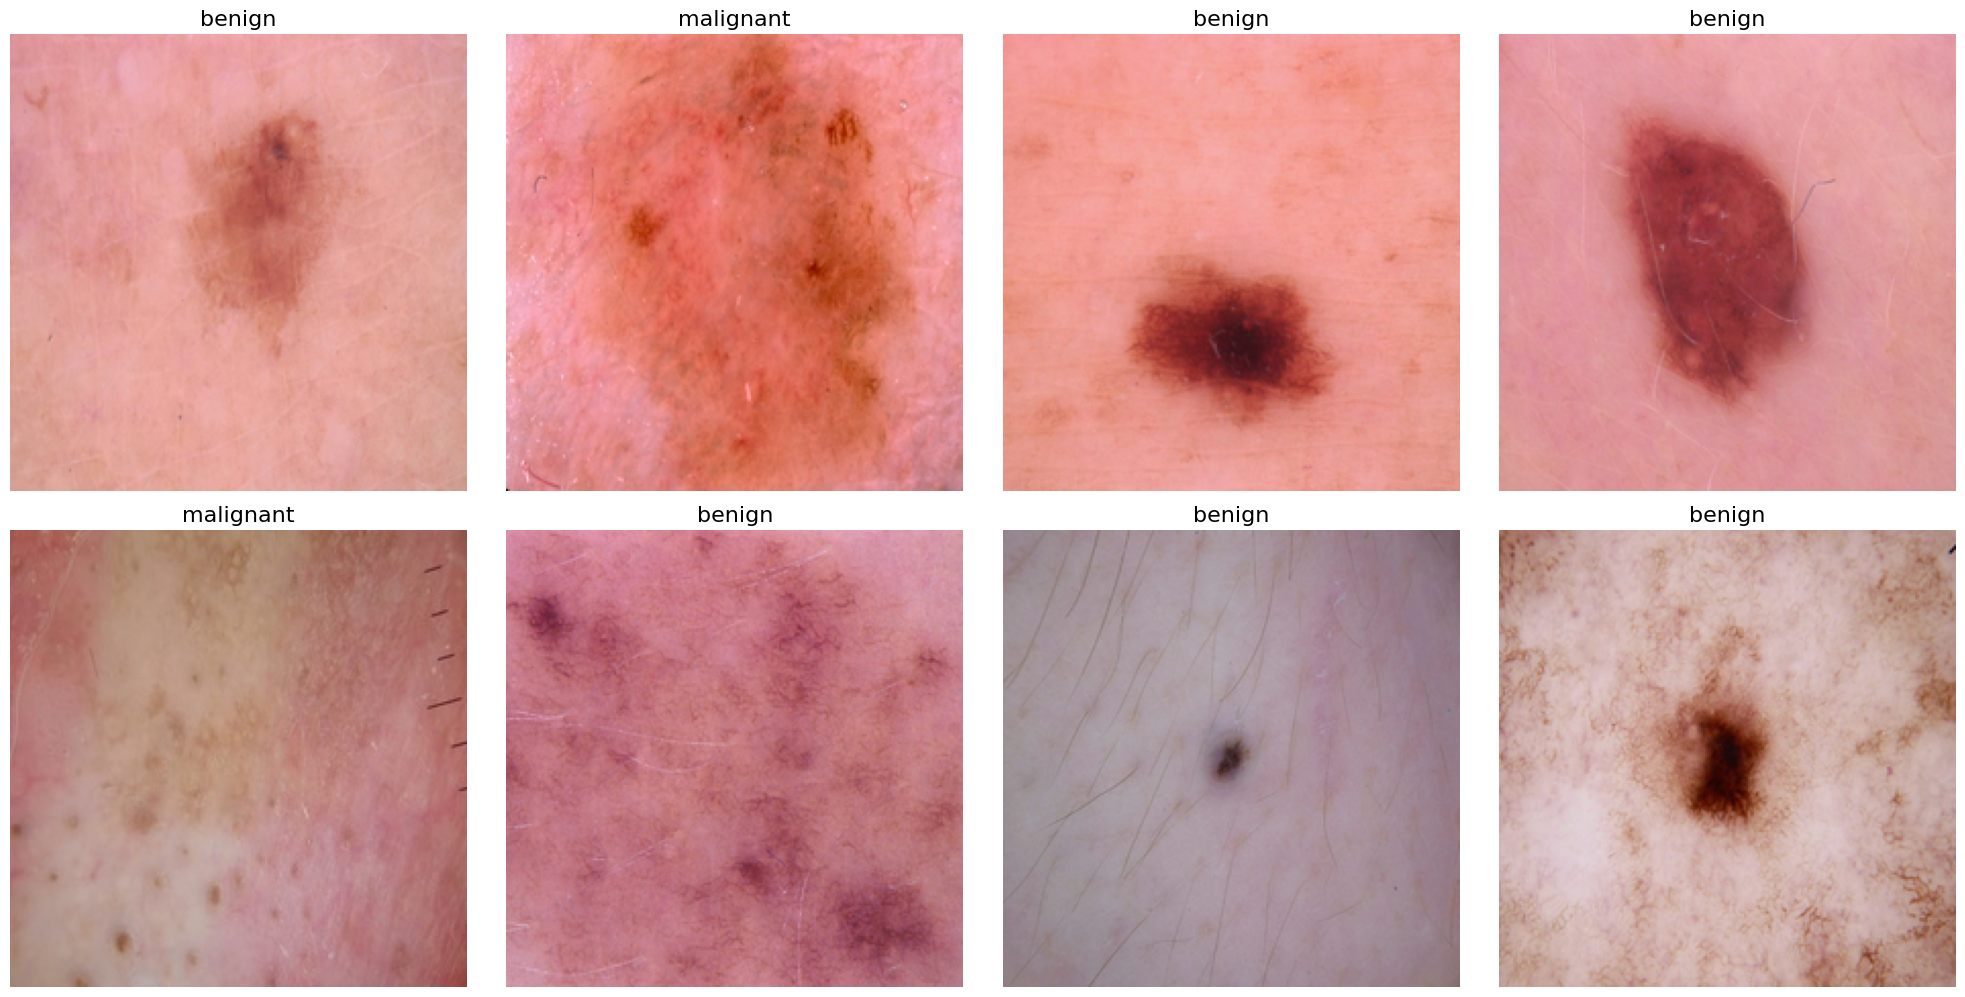

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

# ploting the patch size samples
plt.figure(figsize= (20, 20))

for i in range(batch_size):
    plt.subplot(4, 4, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

# **Create needed functions**

In [ ]:
# Displaying the model performance
def model_performance(history, Epochs):
    # Define needed variables
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    Epochs = [i+1 for i in range(len(tr_acc))]

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()


# Evaluate the model
def model_evaluation(model):
    train_score = model.evaluate(train_gen, verbose= 1)
    valid_score = model.evaluate(valid_gen, verbose= 1)
    test_score = model.evaluate(test_gen, verbose= 1)

    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])


# Confusion Matrix
def plot_confusion_matrix(model, test_gen):
    # Get Predictions
    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis=1)

    g_dict = test_gen.class_indices
    classes = list(g_dict.keys())

    # Display the confusion matrix
    cm = confusion_matrix(test_gen.classes, y_pred)

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')


    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.show()

# **Model Structure**

# **ResNet50**

In [ ]:
# create Model structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_counts = len(list(train_gen.class_indices.keys()))     # to define number of classes in dense layer

In [ ]:
# get the pre-trained model (ResNet50)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape = img_shape, pooling= None)

# freeze the layers in conv5_block3
for layer in base_model.layers:
    if 'conv5_block3' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

# fine-tune ResNet50 (Adding some custom layers on top)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.5)(x)   # Dropout layer to prevent overfitting
x = Dense(32, activation = 'relu')(x)
predictions = Dense(class_counts, activation = "sigmoid")(x)    # output layer with softmax activation

# the model
ResNet50_model = Model(inputs = base_model.input, outputs = predictions)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [ ]:
# Check the trainable status of the layers
for layer in ResNet50_model.layers:
    print(layer.name, layer.trainable)

input_layer False
conv1_pad False
conv1_conv False
conv1_bn False
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_0_bn False
conv2_block1_3_bn False
conv2_block1_add False
conv2_block1_out False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_3_bn False
conv2_block2_add False
conv2_block2_out False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
conv2_block3_3_conv False
conv2_block3_3_bn False
conv2_block3_add False
conv2_block3_out False
conv3_block1_1_conv False
conv3_block1_1_bn False
conv3_block1_1_relu False
conv3_block1_2

In [ ]:
ResNet50_model.compile(optimizer=Adamax(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

ResNet50_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,862,370 (91.03 MB)

 Trainable params: 4,736,226 (18.07 MB)

 Non-trainable params: 19,126,144 (72.96 MB)

**Train the model**

In [ ]:
epochs = 15   # number of all epochs in training

ResNet50_history = ResNet50_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 47s 89ms/step - accuracy: 0.7346 - loss: 0.5455 - val_accuracy: 0.4303 - val_loss: 0.7743
Epoch 2/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.7793 - loss: 0.4473 - val_accuracy: 0.8091 - val_loss: 0.4301
Epoch 3/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.8026 - loss: 0.4211 - val_accuracy: 0.7909 - val_loss: 0.4607
Epoch 4/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.8236 - loss: 0.4008 - val_accuracy: 0.5545 - val_loss: 0.8545
Epoch 5/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.8222 - loss: 0.3853 - val_accuracy: 0.8061 - val_loss: 0.4088
Epoch 6/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.8391 - loss: 0.3675 - val_accuracy: 0.7061 - val_loss: 0.7674
Epoch 7/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.8534 - loss: 0.3528 - val_accuracy: 0.7364 - val_loss: 0.6334
Epoch 8/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.8296 - loss: 0.3624 - 

**Display model performance**

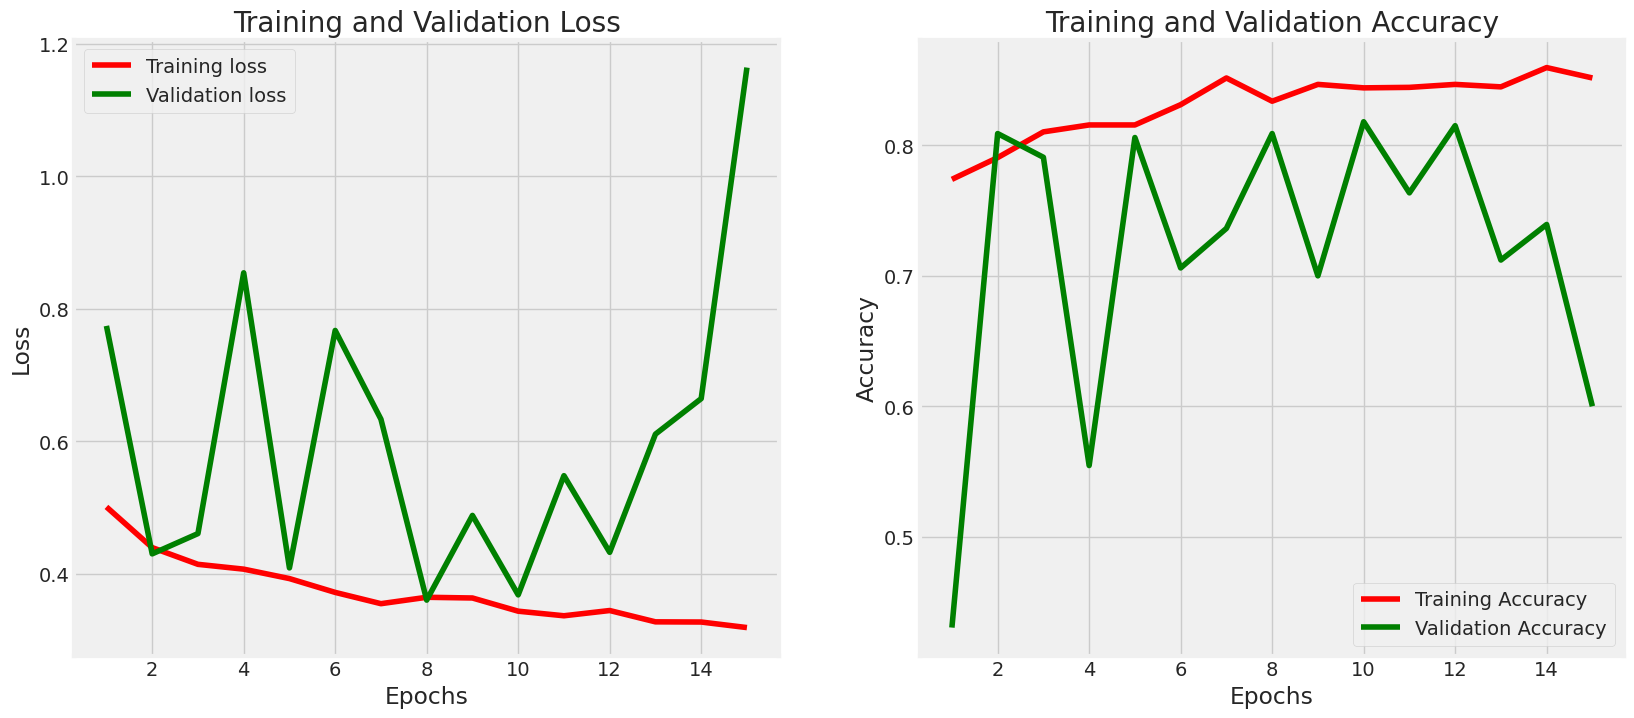

In [ ]:
# Display model performance
model_performance(ResNet50_history, epochs)

**Evaluate the model**

In [ ]:
# Model evaluation
model_evaluation(ResNet50_model)

330/330 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.5885 - loss: 1.0125
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5919 - loss: 1.1598
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6185 - loss: 0.9408
Train Loss:  0.9810368418693542
Train Accuracy:  0.5961319804191589
--------------------
Validation Loss:  1.1643186807632446
Validation Accuracy:  0.6000000238418579
--------------------
Test Loss:  1.0267093181610107
Test Accuracy:  0.6060606241226196


**Get predictions and display the confusion matrix**

42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 234ms/step


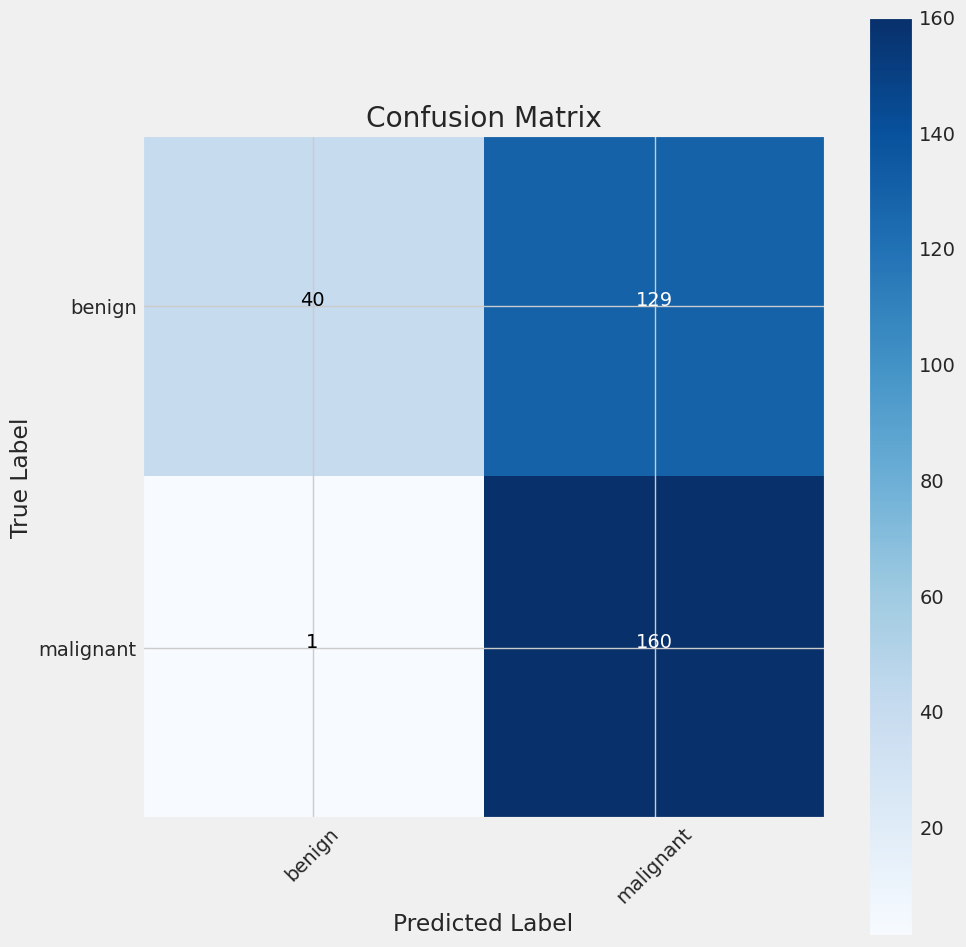

In [ ]:
plot_confusion_matrix(ResNet50_model, test_gen)

# **VGG16**

In [ ]:
# get the pre-trained model (VGG16)
base_model = VGG16(weights='imagenet', include_top=False, input_shape = img_shape, pooling= 'max')

# freeze four convolution blocks
for layer in base_model.layers[:15]:
    layer.trainable = False


# fine-tune VGG16 (Adding some custom layers on top)
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.2)(x)   # # Dropout layer to prevent overfitting
x = Dense(256, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
x = Dense(32, activation = 'relu')(x)
predictions = Dense(class_counts, activation = "sigmoid")(x)    # output layer with softmax activation

# the model
VGG16_model = Model(inputs = base_model.input, outputs = predictions)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# Check the trainable status of the layers
for layer in VGG16_model.layers:
    print(layer.name, layer.trainable)

input_layer_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True
global_max_pooling2d True
flatten True
dense_3 True
dropout_1 True
dense_4 True
dense_5 True
dense_6 True
dense_7 True


In [ ]:
VGG16_model.compile(optimizer=Adamax(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

VGG16_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 512)                 │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │              

 Total params: 15,145,762 (57.78 MB)

 Trainable params: 7,510,498 (28.65 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

**Train the model**

In [ ]:
epochs = 15   # number of all epochs in training

VGG16_history = VGG16_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 43s 99ms/step - accuracy: 0.7576 - loss: 0.5146 - val_accuracy: 0.8152 - val_loss: 0.3708
Epoch 2/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - accuracy: 0.8471 - loss: 0.3486 - val_accuracy: 0.8273 - val_loss: 0.3231
Epoch 3/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 23s 69ms/step - accuracy: 0.8600 - loss: 0.2981 - val_accuracy: 0.8485 - val_loss: 0.3074
Epoch 4/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 23s 69ms/step - accuracy: 0.8840 - loss: 0.2537 - val_accuracy: 0.8424 - val_loss: 0.3162
Epoch 5/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 23s 71ms/step - accuracy: 0.9017 - loss: 0.2285 - val_accuracy: 0.8576 - val_loss: 0.3125
Epoch 6/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 23s 69ms/step - accuracy: 0.9192 - loss: 0.1907 - val_accuracy: 0.8515 - val_loss: 0.3112
Epoch 7/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 42s 71ms/step - accuracy: 0.9348 - loss: 0.1670 - val_accuracy: 0.8485 - val_loss: 0.3286
Epoch 8/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 24s 72ms/step - accuracy: 0.9640 - loss: 0.1151 - 

**Display model performance**

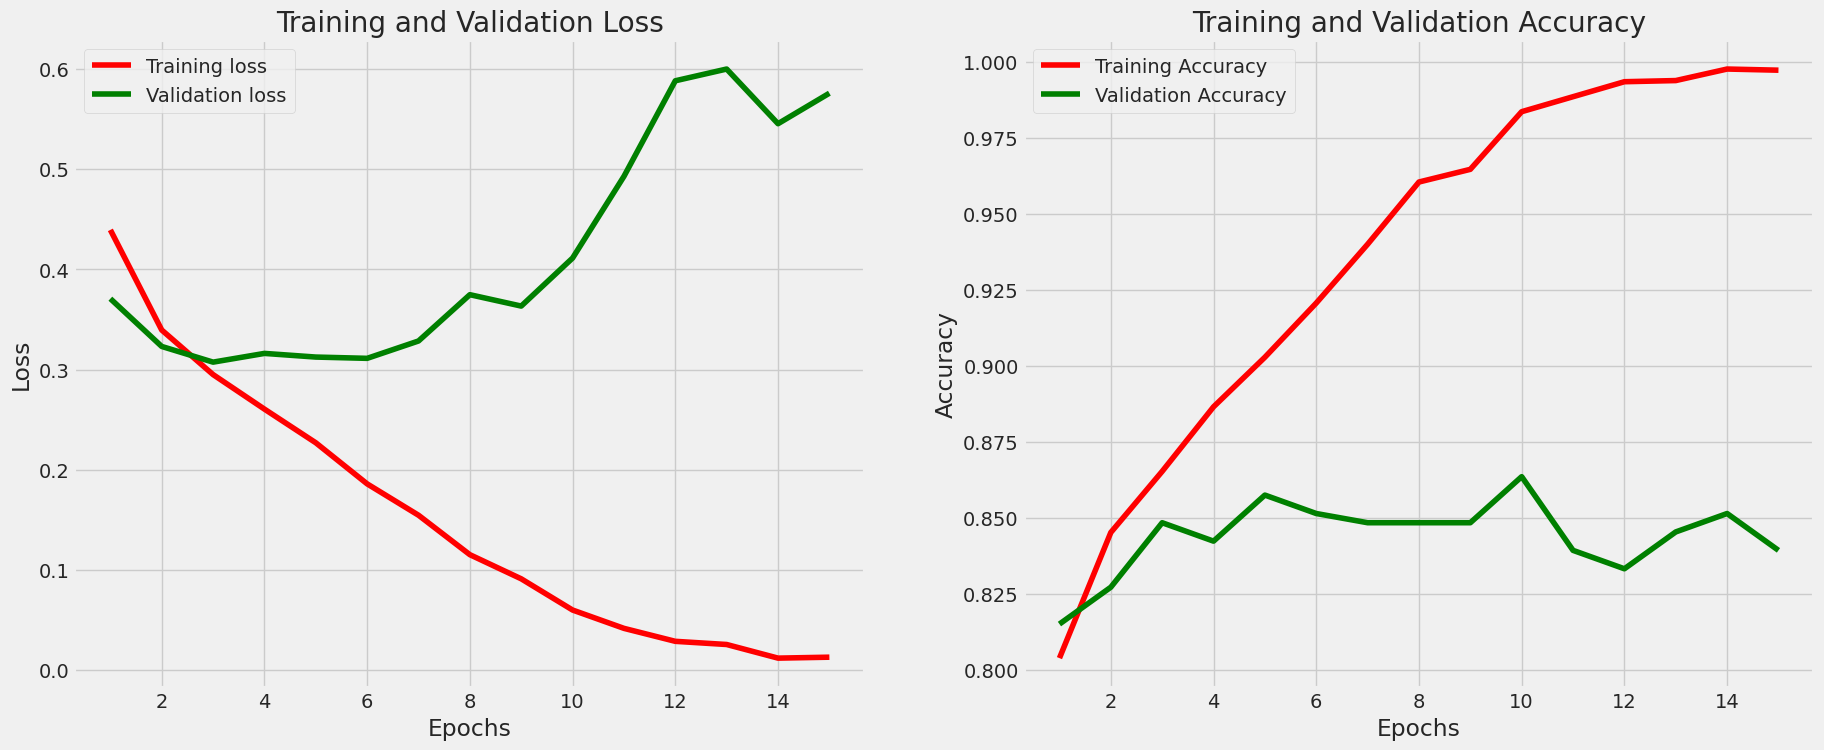

In [ ]:
# Display model performance
model_performance(VGG16_history, epochs)

**Evaluate the model**

In [ ]:
# Model evaluation
model_evaluation(VGG16_model)

330/330 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.9981 - loss: 0.0095
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.8400 - loss: 0.4962
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8588 - loss: 0.5009
Train Loss:  0.006680462043732405
Train Accuracy:  0.9988623261451721
--------------------
Validation Loss:  0.575913667678833
Validation Accuracy:  0.8393939137458801
--------------------
Test Loss:  0.4893040955066681
Test Accuracy:  0.8636363744735718


**Get predictions and display the confusion matrix**

42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step


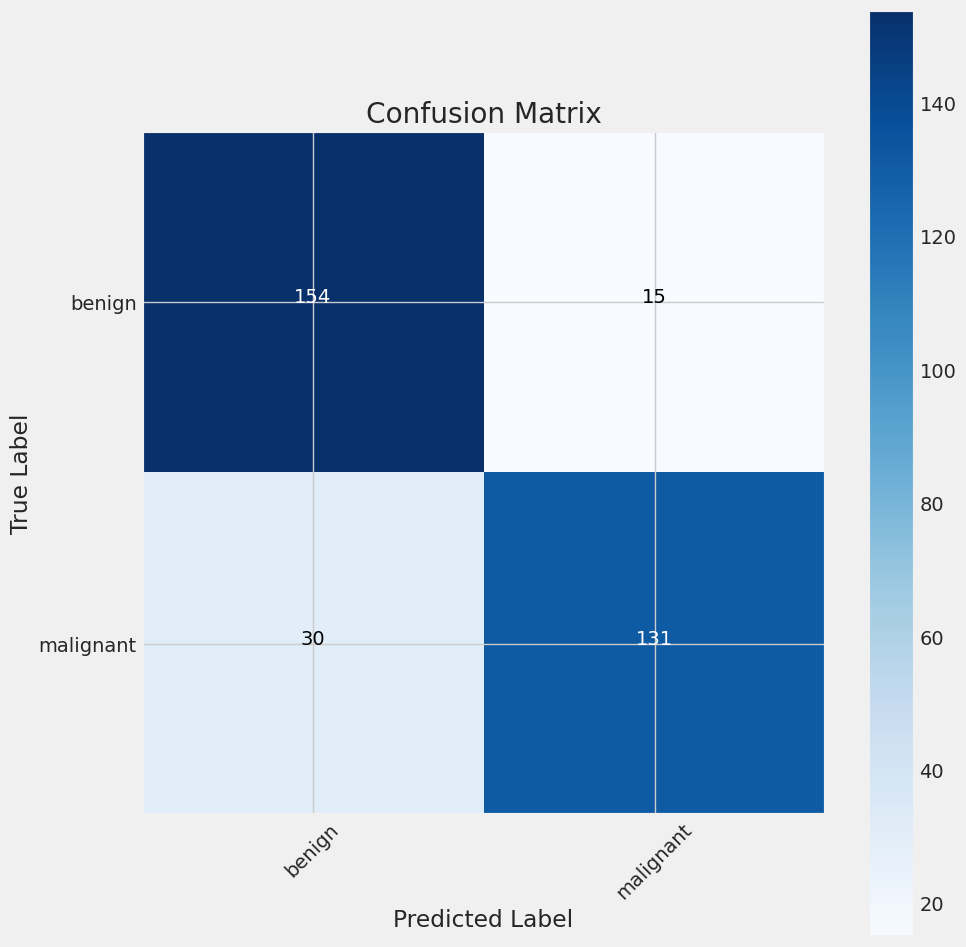

In [ ]:
plot_confusion_matrix(VGG16_model, test_gen)